In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
import statistics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive, files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/LIBOR.csv'
libor_rate = pd.read_csv(path, usecols = ['Date','3M','12M'])
libor_rate['Date'] = pd.to_datetime(libor_rate['Date'], format='%Y-%m-%d')
libor_rate['Date'] = libor_rate['Date'].dt.strftime('%d-%m-%Y')
libor_rate.set_index('Date', inplace=True)
libor_rate.head()

,3M,12M
Date,,
02-01-1986,8.0000,8.0625
03-01-1986,8.0625,8.1250
06-01-1986,8.1250,8.1250
07-01-1986,8.1250,8.1250
08-01-1986,8.0000,8.0625


DATA CLEANING


In [ ]:
#Remove consecutive duplicates
def remove_consecutive_duplicates(libor_rate, col_name):
    #where vede se il valore prima è diverso da quello dopo. se sono uguali lo mette nan
    libor_rate['filtered_series3m'] = libor_rate[col_name].where(libor_rate[col_name].shift() != libor_rate[col_name])

    # Drop the NaN values and reset the index
    filtered_libor_rate = libor_rate.dropna(subset=['filtered_series3m']).reset_index(drop=True)

    return filtered_libor_rate

result_libor_rate = remove_consecutive_duplicates(libor_rate, '3M')

In [ ]:
#Remove consecutive duplicates
def remove_consecutive_duplicates(libor_rate, col_name):
    #where vede se il valore prima è diverso da quello dopo. se sono uguali lo mette nan
    libor_rate['filtered_series12m'] = libor_rate[col_name].where(libor_rate[col_name].shift() != libor_rate[col_name])

    # Drop the NaN values and reset the index
    filtered_libor_rate = libor_rate.dropna(subset=['filtered_series12m']).reset_index(drop=True)

    return filtered_libor_rate

result_libor_rate = remove_consecutive_duplicates(libor_rate, '12M')

In [ ]:
libor_rate = libor_rate.drop(columns=['3M','12M'], axis = 1)
libor_rate = libor_rate.rename(columns={'filtered_series3m': '3M', 'filtered_series12m': '12M' })
libor_rate.dropna(inplace=True)

FORWARD RATES COMPUTATION


In [ ]:
libor_rate[['3M','12M']] = libor_rate[['3M', '12M']] / 100

# Forward rate from 3M to 12M (f1,2)
libor_rate['Forward rate'] = round(((1 + libor_rate['12M'])**(12/12)) / ((1 +libor_rate['3M'])**(3/12)) - 1,5)
libor_rate['Forward rate'] = libor_rate['Forward rate']*100


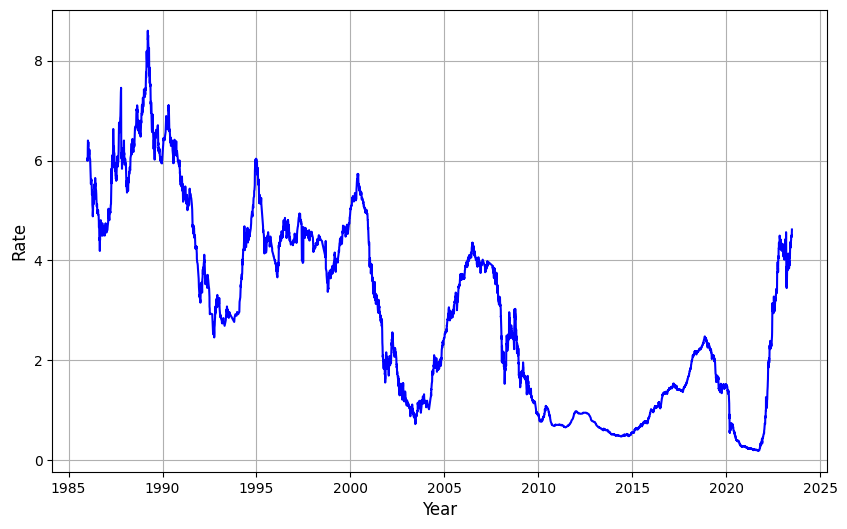

In [ ]:
libor_rate.index = pd.to_datetime(libor_rate.index, dayfirst=True)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(libor_rate.index, libor_rate['Forward rate'], color='blue')
# Adding title and labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/Forward LIBOR rates.png')
plt.show()

SWAP RATE AS STRIKE

In [ ]:
path = '/content/gdrive/MyDrive/GBP 10Y SWAP RATE.csv'
swap_rate = pd.read_csv(path, usecols=['Date','Price'])
swap_rate = swap_rate.iloc[::-1]
swap_rate = swap_rate.reset_index(drop=True)
swap_rate.set_index('Date', inplace=True)
swap_rate=swap_rate['Price']
swap_rate.head()

,Price
Date,
05/22/2018,1.673
05/23/2018,1.610
05/24/2018,1.578
05/25/2018,1.513
05/28/2018,1.516


<ipython-input-35-7a1138b59c30>:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  swap_rate.index=pd.to_datetime(swap_rate.index, dayfirst=True)


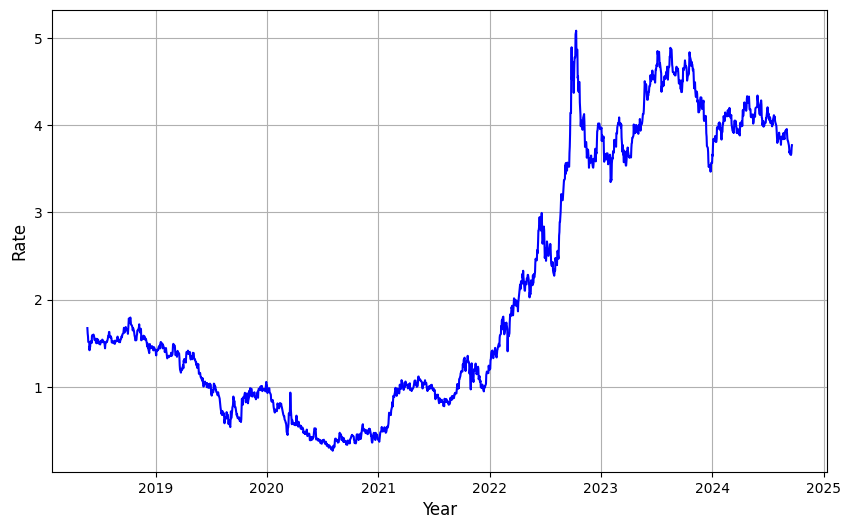

In [ ]:
swap_rate.index=pd.to_datetime(swap_rate.index, dayfirst=True)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(swap_rate, color='blue')
# Adding title and labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/swap_rate.png')
plt.show()

OVERNIGHT INDEXED SWAP ZERO CURVE


In [ ]:
path = '/content/gdrive/MyDrive/ois_data.csv'
ois_data = pd.read_csv(path)
ois_data.set_index('years:', inplace=True)

In [ ]:
Df = pd.DataFrame(index=ois_data.index)
# Iterate over each column and compute the discount factors based on the maturity
for i, maturity in enumerate(ois_data.columns.astype(float)):
    Df[maturity] = np.exp(-ois_data.iloc[:, i] * maturity)

RECEIVER SWAPTION PRICING (CALL)

In [ ]:
N = norm.cdf
def RS_BLACK(P, F, K, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return P * (F * norm.cdf(d1) - K * norm.cdf(d2))
print(f"The price of the receiver swaption is {round(RS_BLACK(Df.loc['30-06-2023'][10], libor_rate.loc['30-06-2023']['Forward rate'], swap_rate.loc['30-06-2023'], 10, 0.40),8)}bps")


The price of the receiver swaption is 1.43146671bps


PAYER SWAPTION PRICING(PUT)

In [ ]:
def PS_BLACK(P, F, K, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return P * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

print(f"The price of the payer swaption is {round(PS_BLACK(Df.loc['30-06-2023'][10], libor_rate.loc['30-06-2023']['Forward rate'], swap_rate.loc['30-06-2023'], 10, 0.40),8)} bps")

The price of the payer swaption is 1.44328555 bps


LOG VOLATILITY COMPUTATION

In [ ]:
libor_rate['log_ret'] = np.log(libor_rate['Forward rate'] / libor_rate['Forward rate'].shift(1))
log_vol= libor_rate['log_ret'].rolling(window=30).std().dropna()

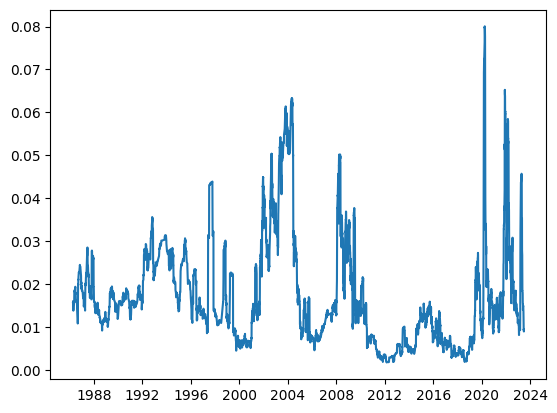

In [ ]:
plt.plot(log_vol)
plt.show()

In [ ]:
#Generates sample paths of fractional Brownian Motion using the Cholesky decomposition
def cholesky_fbm(T, N, H):



    # Define the autocovariance function for fBM
    def gamma(k, H):
        return 0.5 * (np.abs(k - 1)**(2 * H) - 2 * np.abs(k)**(2 * H) + np.abs(k + 1)**(2 * H))

    # Initialize the lower triangular matrix and other necessary vectors
    L = np.zeros((N, N))
    X = np.zeros(N)
    V = np.random.standard_normal(size=N)

    # First row and column initialization
    L[0, 0] = 1.0
    X[0] = V[0]

    # Initialize the second row
    L[1, 0] = gamma(1, H)
    L[1, 1] = np.sqrt(1 - (L[1, 0]**2))
    X[1] = np.sum(L[1, 0:2] @ V[0:2])

    # Cholesky decomposition for the remaining rows
    for i in range(2, N):
        L[i, 0] = gamma(i, H)

        for j in range(1, i):
            L[i, j] = (1 / L[j, j]) * (gamma(i - j, H) - (L[i, 0:j] @ L[j, 0:j]))

        L[i, i] = np.sqrt(1 - np.sum(L[i, 0:i]**2))
        X[i] = L[i, 0:i+1] @ V[0:i+1]

    # Generate the fractional Brownian motion path
    fBm = np.cumsum(X) * (N**(-H))

    # Return the scaled fBM path
    return (T**H) * fBm


In [ ]:
delta = 1/252
n = len(log_vol)
T = n*delta

#Hurst exponent
numerator_H = np.sum([np.abs(log_vol.iloc[i] - 2 * log_vol.iloc[i-2] + log_vol.iloc[i-4])**2 for i in range(4, n)])
denominator_H = np.sum([np.abs(log_vol.iloc[i] - 2 * log_vol.iloc[i-1] + log_vol.iloc[i-2])**2 for i in range(2, n)])
H_hat = 0.5 * np.log2(numerator_H / denominator_H)

#Sigma estimation
tau = 4 * delta**(2 * H_hat) - (2 * delta)**(2 * H_hat)
sigma_hat = np.sqrt((delta / (T * tau)) * denominator_H)

#mu estimation
mu_hat = np.mean(log_vol)

#kappa estimation
kappa_hat = (n * np.sum(log_vol**2) - np.sum(log_vol)**2) / (n**2 * sigma_hat**2 * H_hat * math.gamma(2 * H_hat))
kappa_hat = kappa_hat**(-1 / (2 * H_hat))


print(f"H = {H_hat}, sigma = {sigma_hat}, mu = {mu_hat}, kappa = {kappa_hat}")

H = 0.5015166777295165, sigma = 0.019314451117442295, mu = 0.01668179050259855, kappa = 1.1798671433685817


In [ ]:
np.random.seed(42)

t_values = np.linspace(0, T, n) #generates an array of evenly spaced times

# Simulate the fractional Brownian motion
fbm=cholesky_fbm(T, n, H_hat)

# Initialize the process X_t
X_t = np.zeros(n)
X_t[0] = log_vol.iloc[0]  # Starting point from the data

# Simulate the fOU process with euler maruyama method
for i in range(1, n):
    dt = t_values[i] - t_values[i-1]
    X_t[i] = X_t[i-1] + kappa_hat * (mu_hat - X_t[i-1]) * dt + sigma_hat * (fbm[i] - fbm[i-1])

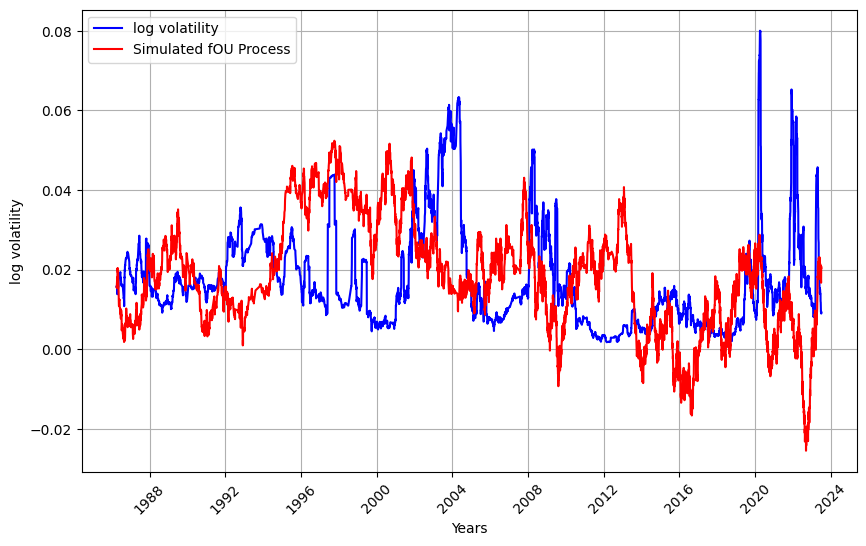

In [ ]:
X_t = pd.Series(X_t, index=log_vol.index)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(log_vol.index, log_vol, label="log volatility", color='blue')
plt.plot(X_t.index, X_t, label="Simulated fOU Process", color='red')

# Formatting the plot
plt.xlabel("Years")
plt.ylabel("log volatility")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Use matplotlib date formatting to manage the date labels on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year-month
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust date ticks

plt.grid(True)

plt.savefig('/content/gdrive/MyDrive/log_volatility_fOU_plot.png') #saving image

plt.show()

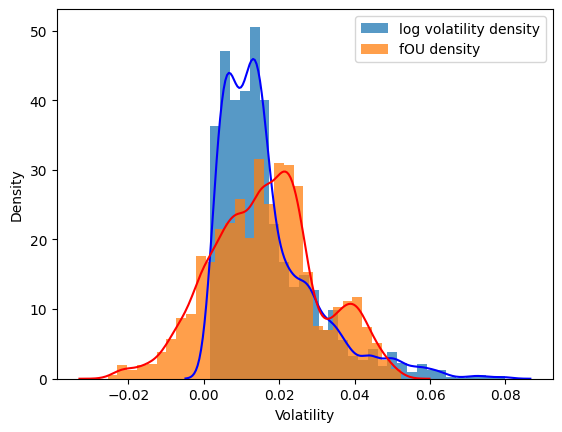

In [ ]:
# Create the histogram
plt.hist(log_vol, density=True, alpha=0.75, label='log volatility density', bins=30)  # Add transparency with alpha
plt.hist(X_t, density=True, alpha=0.75, label='fOU density', bins=30)  # Add transparency with alpha

# Add density lines using seaborn for smoother appearance
sns.kdeplot(log_vol, color='blue')
sns.kdeplot(X_t, color='red')

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Density')

# Add a legend to differentiate the two datasets
plt.legend()

plt.savefig('/content/gdrive/MyDrive/volatility_density_plot.png')

# Show the plot
plt.show()


MAE and MSE

In [ ]:
round(mean_absolute_error(log_vol, X_t),5),round(mean_squared_error(log_vol, X_t),5)

(0.01465, 0.00033)

In [ ]:
X_t=np.exp(X_t)

SWAPTION PRICING WITH ESTIMATED VOLATILITY

In [ ]:
def RS_BLACK_fOU(P, F, K, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return P * (F * norm.cdf(d1) - K * norm.cdf(d2))
print(f"The price of the receiver swaption is {round(RS_BLACK_fOU(Df.loc['30-06-2023'][10], libor_rate.loc['30-06-2023']['Forward rate'], swap_rate.loc['30-06-2023'], 10, X_t.loc['30-06-2023']),8)}bps")


The price of the receiver swaption is 2.70950235bps


In [ ]:
def PS_BLACK_fOU(P, F, K, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return P * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

print(f"The price of the payer swaption is {round(PS_BLACK_fOU(Df.loc['30-06-2023'][10], libor_rate.loc['30-06-2023']['Forward rate'], swap_rate.loc['30-06-2023'], 10, X_t.loc['30-06-2023']),8)} bps")

The price of the payer swaption is 2.72132119 bps


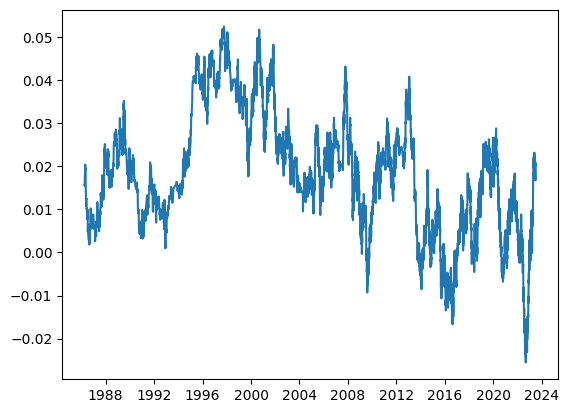

In [ ]:
plt.plot(np.log(X_t))
plt.show()

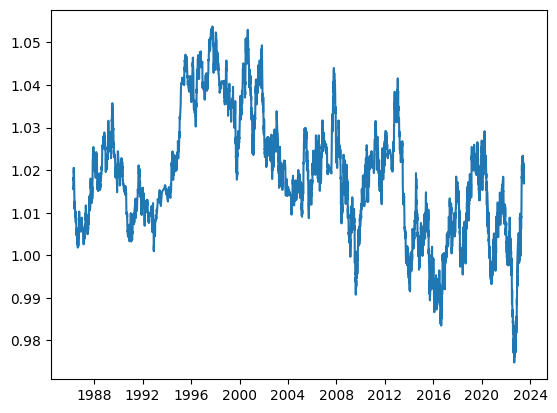

In [ ]:
plt.plot(X_t)
plt.show()